In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
from shapely import LineString
from sthype.plot import plot_spatial_temporal_graph, plot_spatial_temporal_graph_node, plot_spatial_graph, plot_spatial_temporal_graph_hyperedge


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[1]
path_tot = os.path.join(path_root,f"graph{plate_id}.pickle")
spatial_temporal_graph,folders = load(path_tot)
len(spatial_temporal_graph)

91895

In [3]:
exp = make_exp(spatial_temporal_graph,folders,make_pixel_list=True)

spatial_temporal_graph = simplify(spatial_temporal_graph)
fix_attributes(spatial_temporal_graph)
exp = make_exp(spatial_temporal_graph,folders)

78113
107
1


In [ ]:
len(spatial_temporal_graph)

In [4]:
import networkx as nx
from matplotlib import cm
from sthype import SpatialTemporalGraph
from sthype.plot.utils import in_region, random_color


def plot_spatial_temporal_graph2(
    stg: SpatialTemporalGraph,
    ax,
    color_group: str | int = "uniform",
    time: int = -1,
    region: None | tuple[tuple[float, float], tuple[float, float]] = None,
    add_nodes: bool = False,
    add_initial_nodes: bool = False,
    **kwargs,
):
    """Plot Spatial Temporal Graph

    Parameters
    ----------
    stg : SpatialTemporalGraph
        Spatial Temporal Graph to plot
    color_group : str | int, optional
        color group to color edge: 'random'/'edge', 'activation',
        'initial_edge', 'hyperedge'. If int, color the corresponding hyperedge in red.
        By default "uniform"
    time : int, optional
        Plot Spatial Temporal Graph at time t, by default -1
    region : None | tuple[tuple[float, float], tuple[float, float]], optional
        Region to plot, by default None
    add_nodes : bool, optional
        plot nodes, by default False
    add_initial_nodes : bool, optional
        plot initial nodes, by default False
    """
    if region:
        edgelist = []
        for node1, node2 in stg.edges:
            if in_region(stg.positions[node1], region) or in_region(
                stg.positions[node2], region
            ):
                edgelist.append((node1, node2))
    else:
        edgelist = list(stg.edges())

    if time >= 0:
        edgelist = [
            edge
            for edge in edgelist
            if stg[edge[0]][edge[1]]["post_hyperedge_activation"] <= time
        ]

    colors = []
    edge_labels = {}
    if color_group == "random" or color_group == "edge":
        colors = [random_color() for _ in edgelist]
    elif color_group == "activation":
        activations = [
            stg[node1][node2]["post_hyperedge_activation"] for node1, node2 in edgelist
        ]
        max_activation = stg.max_age
        colors = [cm.viridis(activation / max_activation) for activation in activations]
    elif color_group == "initial_edge":
        colors_dict = {
            initial_edge: random_color() for initial_edge in stg.initial_edges_edges
        }
        edges_initial_edge = [
            stg[edge[0]][edge[1]]["initial_edge"] for edge in edgelist
        ]
        edges_initial_edge = [
            (min(initial_edge), max(initial_edge))
            for initial_edge in edges_initial_edge
        ]
        colors = [colors_dict[initial_edge] for initial_edge in edges_initial_edge]
    elif color_group == "hyperedge":
        colors_dict = {
            hyperedge: random_color() for hyperedge in stg.hyperedges_initial_edges
        }
        colors = [
            colors_dict[stg[node1][node2]["hyperedge"]] for node1, node2 in edgelist
        ]
    elif isinstance(color_group, int):
        colors = [
            "red" if stg[node1][node2]["hyperedge"] == color_group else "blue"
            for node1, node2 in edgelist
        ]
    else:
        colors = "k"

    pos = {node: (point.x, point.y) for node, point in stg.positions.items()}
    hyperedges = {}
    # Extracting hyperedge numbers for labeling
    for edge in edgelist:
        hyperedge_number = stg[edge[0]][edge[1]]["hyperedge"]
        midpoint = ((pos[edge[0]][0] + pos[edge[1]][0]) / 2, (pos[edge[0]][1] + pos[edge[1]][1]) / 2)
        hyperedges[edge[0]] =hyperedge_number
        ax.text(midpoint[0], midpoint[1], f'#{hyperedge_number}', color='red', fontsize=0.2, ha='center', va='center',rasterized = True)

    nx.draw_networkx(
        stg,
        pos=pos,
        with_labels=add_nodes,
        nodelist=[],
        edgelist=edgelist,
        edge_color=colors,
        # labels = hyperedges,
        **kwargs,
    )


In [5]:
mpl.rcParams["figure.dpi"] = 2000


In [ ]:
fig,ax = plt.subplots()
plot_spatial_temporal_graph2(spatial_temporal_graph,ax, color_group='hyperedge')
plt.savefig("test.png")

In [8]:
def merge_hyperedge(hyperdege0,hyperedge1,graph):
    edges = graph.get_hyperedge_edges(hyperedge1)
    edges_new = merge(edges, graph)
    for u,v in edges_new:
        graph[u][v]["hyperedge"] = hyperdege0

In [13]:
#441
merge_hyperedge(3169,3728,spatial_temporal_graph)
merge_hyperedge(3169,3874,spatial_temporal_graph)
#310
# merge_hyperedge(335,443,spatial_temporal_graph)
# merge_hyperedge(31,133,spatial_temporal_graph)
# merge_hyperedge(242,171,spatial_temporal_graph)
# merge_hyperedge(1586,673,spatial_temporal_graph)
# merge_hyperedge(1586,780,spatial_temporal_graph)
# merge_hyperedge(167,1583,spatial_temporal_graph)
# merge_hyperedge(167,640,spatial_temporal_graph)
#449
merge_hyperedge(221,263,spatial_temporal_graph)
merge_hyperedge(221,445,spatial_temporal_graph)
merge_hyperedge(221,579,spatial_temporal_graph)
merge_hyperedge(221,1243,spatial_temporal_graph)
merge_hyperedge(697,672,spatial_temporal_graph)
merge_hyperedge(697,480,spatial_temporal_graph)
merge_hyperedge(697,4824,spatial_temporal_graph)
merge_hyperedge(697,1301,spatial_temporal_graph)
merge_hyperedge(1244,1224,spatial_temporal_graph)
merge_hyperedge(1244,1333,spatial_temporal_graph)
merge_hyperedge(1244,4852,spatial_temporal_graph)


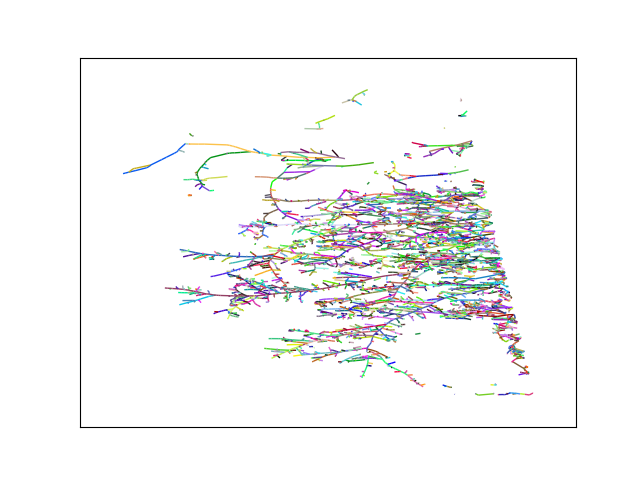

In [14]:
mpl.rcParams["figure.dpi"] = 100

fig,ax = plt.subplots()
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='hyperedge')
# plt.savefig("test.png")

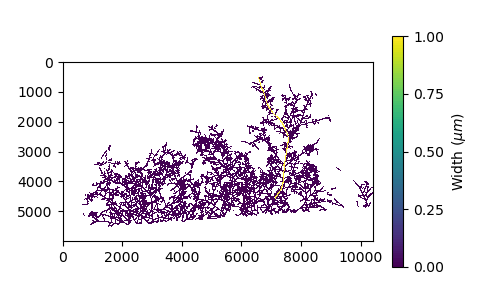

(<Figure size 500x300 with 2 Axes>, <AxesSubplot: >)

In [23]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 1
vmin = 0
t=0
# region = [[3000*5,5000*5],[5250*5,7500*5]]
region = [[0*5,0*5],[30000,52000]]

plot_edge_color_value(
    exp,
    t,
    lambda edge : edge.get_attribute("hyperedge",t) ==3169,
    # lambda edge : 2,
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=30,
    figsize=(5, 3),
    alpha = 1,
    region = region
)

In [41]:
spatial_temporal_graph[u][v]['pixel_list'][0][0]

22974.486624024063

In [47]:
weights = {(begin, end): LineString(data['pixel_list']).length * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "length")
weights = {(begin, end): data['pixel_list'][0][0] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "x")
weights = {(begin, end): data['pixel_list'][0][1] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "y")
spatial_temporal_graph._hyperedges_initial_edges_gathered = True
get_abcisse(spatial_temporal_graph)

KeyError: 26362

In [ ]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 30000
vmin = 0
t=0
# region = [[3000*5,5000*5],[5250*5,7500*5]]
region = [[0*5,0*5],[30000,52000]]

plot_edge_color_value(
    exp,
    t,
    lambda edge : (edge.get_attribute("hyperedge",t) ==3169)*edge.get_attribute("x",t),
    # lambda edge : 2,
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=30,
    figsize=(5, 3),
    alpha = 1,
    region = region
)

In [ ]:
# folders = folders.transpose()
folders = folders.sort_values(by="datetime")

In [ ]:
index0 = 5
index1 = 8
exp1 = add_fluxes(exp,index0,index1,folders)

In [ ]:
fig,ax = plt.subplots()
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='hyperedge',ax=ax)

In [ ]:
edges_new = merge(edges,exp1.nx_graph[0])
backflow_speeds = [(exp1.nx_graph[0][u][v]["speed_backflow"])*(2*(u>v)-1) for (u,v) in edges_new]
lengths = [(exp1.nx_graph[0][u][v]["length"]) for (u,v) in edges_new]
activations = [(spatial_temporal_graph[u][v]["post_hyperedge_activation"]) for (u,v) in edges_new]
if activations[0]>activations[-1]:
    activations.reverse()
    lengths.reverse()    
    backflow_speeds.reverse()    
abcisse = np.cumsum(lengths)


In [ ]:
activations

In [ ]:
list(abcisse).reverse()

In [ ]:
fig,ax = plt.subplots()
ax.scatter(abcisse,backflow_speeds)

In [ ]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 10
vmin = 0
t=0
region = [[3000*5,5000*5],[5250*5,7500*5]]
# region = [[0*5,0*5],[30000,52000]]

plot_edge_color_value(
    exp,
    t,
    lambda edge : edge.get_attribute("post_hyperedge_activation",t),
    # lambda edge : 2,
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=30,
    figsize=(5, 3),
    alpha = 1,
    region = region
)

In [ ]:
fix_attributes(spatial_temporal_graph_simple)

In [ ]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 1
vmin = 0
t=0
# region = [[3000*5,5000*5],[5250*5,7500*5]]
region = [[0*5,0*5],[30000,52000]]

plot_edge_color_value(
    exp,
    t,
    lambda edge : edge.get_attribute("hyperedge",t) in long_hyperedges,
    # lambda edge : 2,
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=30,
    figsize=(5, 3),
    alpha = 1,
    region = region
)

In [ ]:
refs = {
    "310_20230830": {
        "20230901_Plate310": "20230901_0719_Plate06",
        "20230902_Plate310": "20230902_1343_Plate07",
        "20230903_Plate310": "20230903_1143_Plate07",
        "20230904_Plate310": "20230904_0942_Plate07",
        "20230905_Plate310": "20230905_1345_Plate07",
        # "20230906_Plate310" : "20230906_1220_Plate07",
    },
    "441_20230807": {
        # "20230810_Plate441": "20230810_1005_Plate14",
        "20230811_Plate441": "20230811_1605_Plate14",
        "20230812_Plate441": "20230812_1006_Plate14",
        "20230813_Plate441": "20230813_1618_Plate14",
    },
    "449_20230807": {
        "20230813_Plate449": "20230813_1606_Plate10",
        "20230814_Plate449": "20230814_1019_Plate10",
        "20230815_Plate449": "20230815_1021_Plate10",
        "20230816_Plate449": "20230816_1027_Plate10",
        # "20230818_Plate449": "20230818_1107_Plate10",
    },
}
indexes = refs[plate_id]
for plate_id_video in list(indexes.keys()):
    index0 = np.where(folders["folder"] == indexes[plate_id_video])[0][0]
    index1 = index0+1
    break

In [ ]:
exp = make_exp(spatial_temporal_graph_simple,folders)


In [ ]:
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 10
vmin = 0
t=0
region = [[3000*5,5000*5],[5250*5,7500*5]]
# region = [[0*5,0*5],[26000,52000]]

fig,ax = plt.subplots()
plot_edge_color_value(
    exp,
    t,
    lambda edge : edge.get_attribute("post_hyperedge_activation",t),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    figax = (fig,ax),
    region = region,
    label_colorbar = "activation timestep"
)


In [ ]:
index0 = 0 
index1 = 8
weights, nodes_exp = get_growing_nodes(exp,index0,index1)

In [ ]:
r0 = 3
nodes_source = [node for node in nodes_exp if weights[node]/(np.pi*r0**2)*3600 >10]
nodes_source = [node for node in nodes_source if weights[node]/(np.pi*r0**2)*3600 <=1000]


In [ ]:
G = create_subgraph_by_attribute(spatial_temporal_graph_simple, "post_hyperedge_activation", index1)
exp0 = make_exp(G,folders)

In [ ]:

from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

from matplotlib import cm
vmax = 1
vmin = 0
t=0
# region = [[3750*5,4500*5],[5250*5,8000*5]]
# region = [[0*5,0*5],[26000,52000]]

fig,ax = plt.subplots()
plot_edge_color_value_3(
    exp0,
    t,
    lambda edge : 1-(edge.get_attribute("post_hyperedge_activation",t)<=index0),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    figax = (fig,ax),
    region = region,
    nodes = nodes_source
)


In [ ]:
G0 = create_subgraph_by_attribute(spatial_temporal_graph_simple, "post_hyperedge_activation", index0)
components = nx.connected_components(G0)
largest_component = max(components, key=len)
largest_component_graph = create_subgraph_from_nodelist(G0,largest_component)

exp1 = make_exp(largest_component_graph,folders)

In [ ]:
for _,_,data in largest_component_graph.edges(data=True) :
    break
data

In [ ]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.add_BC import *
nodes = get_all_nodes(exp1,0)
nodes_sink = [node for node in nodes if get_min_activation(largest_component_graph,node.label)<=index0]
nodes_sink = find_lowest_nodes(nodes_sink, 0,15)
nodes_source = [node for node in nodes_source if node in nodes]

In [ ]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

from matplotlib import cm

vmax = 1
vmin = 0
t=0
# region = [[3750*5,4500*5],[5250*5,8000*5]]
# region = [[0*5,0*5],[28000,52000]]

fig,ax = plt.subplots()
plot_edge_color_value_3(
    exp1,
    t,
    lambda edge : 1-(edge.get_attribute("post_hyperedge_activation",t)<=index0),
    
    cmap=cm.get_cmap("viridis", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    figax = (fig,ax),
    region = region,
    nodes = nodes_source
)


In [ ]:
add_lipid_flux(exp1.nx_graph[0],nodes_source,nodes_sink,weights)

In [ ]:
# region = [[3750*5,4500*5],[5250*5,8000*5]]

plot_region(exp1,region,"QBC_net",10)

In [ ]:
edges = get_all_edges(exp1,0)
densities = [abs(data["QBC_net"]/(np.pi*data[str(index0)]['width']**2*3)) for _,_,data in largest_component_graph.edges(data=True)]
fig,ax = plt.subplots()
ax.hist(speeds,20)
ax.set_yscale("log")

In [ ]:
add_flows_heaton(exp1.nx_graph[0],nodes_source,nodes_sink,weights,index0)

In [ ]:
G = exp1.nx_graph[0]
speeds = [abs(G[u][v]['speed_heaton']) for u, v in G.edges()]
fluxes = [G[u][v]['QBC_net'] for u, v in G.edges()]
fig,ax = plt.subplots()
ax.hist(speeds,30)
# ax.hist(fluxes2,30,alpha = 0.5)
ax.set_yscale("log")

In [ ]:
region = [[3750*5,4500*5],[5250*5,8000*5]]

plot_region(exp1,region,"speed_heaton",0.3)

In [ ]:
add_backflows(exp1.nx_graph[0],nodes_source,nodes_sink,index0)

In [ ]:
G = exp1.nx_graph[0]
speeds = [abs(G[u][v]['speed_backflow']) for u, v in G.edges()]
fig,ax = plt.subplots()
ax.hist(speeds,30)
# ax.hist(fluxes2,30,alpha = 0.5)
ax.set_yscale("log")

In [ ]:
region = [[3750*5,4500*5],[5250*5,8000*5]]

plot_region(exp1,region,"speed_backflow",0.3)

In [ ]:
fig,ax = plt.subplots()
weights_list = [weights[node]/(np.pi*r0**2)*3600 for node in nodes_source]
ax.hist(weights_list,30)
print(np.sum(weights_list)/3600)
# ax.hist(fluxes2,30,alpha = 0.5)
# ax.set_yscale("log")

In [ ]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *
from matplotlib import cm
downsizing = 5
t=0

fig, ax,f = plot_edge_color_value_3(
    exp1,
    t,
    lambda edge : abs(edge.get_attribute("speed",t)),
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    v_min = 0,
    v_max = 0.2,
    region = [[3750*5,4500*5],[5250*5,8000*5]]
    # nodes = non_zero

)